In [8]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from joblib import load, dump

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE


In [9]:
# 2. Load cleaned dataset
base_dir = Path.cwd().parent  # if you're inside /notebooks/
data_path = base_dir / 'data' / 'cleaned_data_jobs.csv'

In [10]:
df = pd.read_csv(data_path)
print("✅ Cleaned data loaded:", df.shape)

✅ Cleaned data loaded: (17880, 2)


In [13]:
# 3. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['fraudulent']

In [14]:
# 4. Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [15]:
print("Before SMOTE - class balance:\n", y_train.value_counts(normalize=True) * 100)

Before SMOTE - class balance:
 fraudulent
0    95.155201
1     4.844799
Name: proportion, dtype: float64


In [16]:
# 5. Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE - class balance:\n", pd.Series(y_train_resampled).value_counts(normalize=True) * 100)

After SMOTE - class balance:
 fraudulent
0    50.0
1    50.0
Name: proportion, dtype: float64


In [17]:
# 6. Train Random Forest on resampled data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# 7. Predict on original test set
y_pred = rf.predict(X_test)


In [18]:
# 8. Evaluation: classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))


📊 Classification Report:
              precision    recall  f1-score   support

        Real       0.98      1.00      0.99      3403
        Fake       0.99      0.64      0.78       173

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.88      3576
weighted avg       0.98      0.98      0.98      3576



C:\Users\palre\AppData\Local\Temp\ipykernel_20692\3802339520.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Real', 'Fake'])
C:\Users\palre\AppData\Local\Temp\ipykernel_20692\3802339520.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Real', 'Fake'])


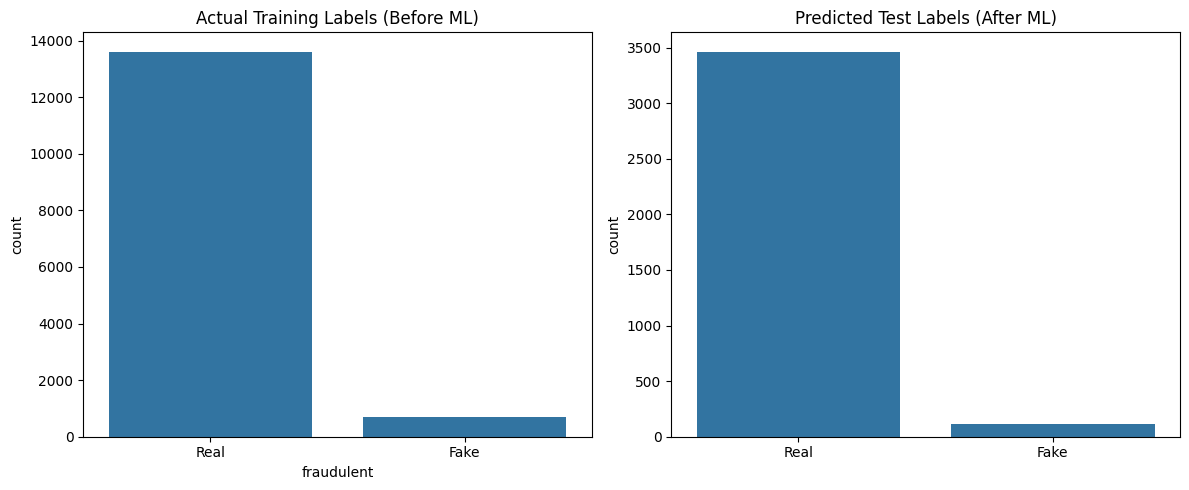

In [21]:
# 9. Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Actual Training Labels (Before ML)")
axes[0].set_xticklabels(['Real', 'Fake'])

sns.countplot(x=y_pred, ax=axes[1])
axes[1].set_title("Predicted Test Labels (After ML)")
axes[1].set_xticklabels(['Real', 'Fake'])

plt.tight_layout()
plt.show()

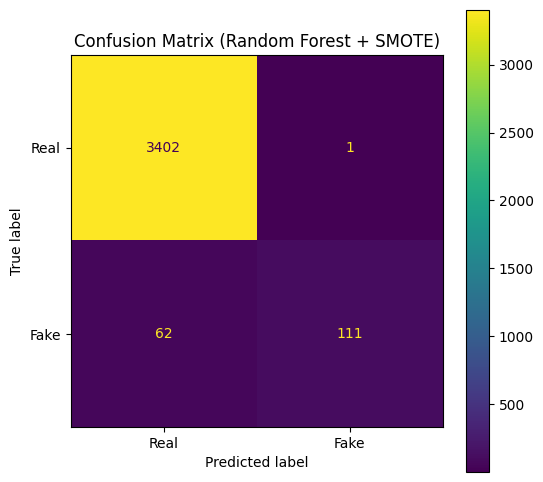

✅ Model and vectorizer saved to /models/


In [22]:
# 10. Confusion matrix
fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Real', 'Fake'], ax=ax_cm)
ax_cm.set_title("Confusion Matrix (Random Forest + SMOTE)")
plt.show()

# 11. Save trained model and vectorizer
model_dir = base_dir / 'models'
model_dir.mkdir(parents=True, exist_ok=True)

dump(rf, model_dir / 'random_forest_model.joblib')
dump(tfidf, model_dir / 'tfidf_vectorizer.joblib')

print("✅ Model and vectorizer saved to /models/")
